In [488]:
%display latex

# Calculating turn maneuvers for path smoothing

In this document, I will explain the method I developed for path smoothing. This technique takes an arbitrary set of points to form a path. Then, taking into account the traveling agent's acceleration and maximum rotational velocity, it smooths out the turns. Throughout this process, the method ensures consistent acceleration and deceleration along the path.

I plan to apply this method to calculate spacecraft maneuvers based on a path generated by a pathfinding algorithm. It's important to note that this method won't be entirely physically accurate. I've made a simplification: during a turn, the spacecraft can transfer 100% of its momentum towards the new directn. This will become more obvious from the equations I will use.. 

## Straight line maneuver

Given acceleration (a) with initial velocity (v_0) and time (t) we can formulate the agent's velocity at any point of time by using the following formula:

In [489]:
var('v_0 a t v')

straight_velocity = v == v_0 + a * t

straight_velocity

v == a*t + v_0

### Where

- `v`: Velocity
- `v_0`: Initial velocity
- `a`: Acceleration
- `t`: Time

By integrating the velocity formula in terms of `t` we can get positional displacement

In [490]:
from sage.symbolic.integration.integral import indefinite_integral

var('d d_0')

straight_displacement = d == d_0 + indefinite_integral(straight_velocity.rhs(), t)

straight_displacement

d == 1/2*a*t^2 + t*v_0 + d_0

Let's introduce angle `theta`, that will be used to specify the direction of the acceleration maneuver and split the equation into `x` and `y` components. We can also use `x_0` and `y_0` as the starting position coordinates.

In [491]:
var('theta x y x_0 y_0')

straight_displacement_x = x == x_0 + indefinite_integral(straight_velocity.rhs(), t) * cos(theta)
straight_displacement_y = y == y_0 + indefinite_integral(straight_velocity.rhs(), t) * sin(theta)

[straight_displacement_x, straight_displacement_y]

[x == 1/2*(a*t^2 + 2*t*v_0)*cos(theta) + x_0,
 y == 1/2*(a*t^2 + 2*t*v_0)*sin(theta) + y_0]

Let's try to print a test acceleration from position `[50, 100]` at angle of `PI / 4` lasting 2 seconds, having no initial velocity and acceleration of `5`.

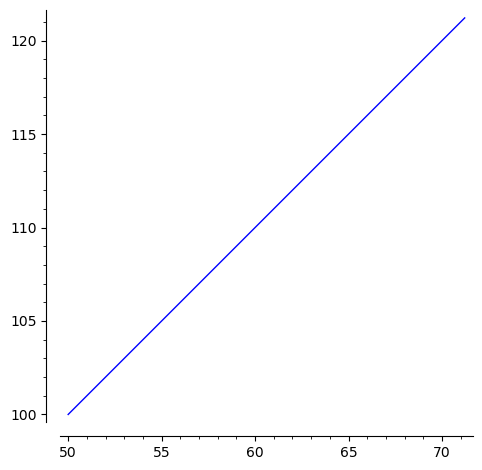

In [492]:
test_straight_displacement = [
    expr.subs(v_0 = 10, a = 5, theta = pi / 4, x_0 = 50, y_0 = 100)
    for expr in [straight_displacement_x, straight_displacement_y]
]

parametric_plot((test_straight_displacement[0].rhs(), test_straight_displacement[1].rhs()), (t, 0, 2))

Deceleration will be using the same formulas, the `a` variable however, will be negative.

## Turn maneuver

Let's start by defining the turn velocity. This time we'll already use parametric form:

In [493]:
var('v_0 a t v_x v_y theta_0 omega')

turn_velocity_x = v_x == (v_0 + a * t) * cos(theta_0 + omega * t)
turn_velocity_y= v_y == (v_0 + a * t) * sin(theta_0 + omega * t)

[turn_velocity_x, turn_velocity_y]

[v_x == (a*t + v_0)*cos(omega*t + theta_0),
 v_y == (a*t + v_0)*sin(omega*t + theta_0)]

### Where

- `v_0` is the initial velocity before starting the turn
- `a` is an acceleration during the turn
- `t` is the time elapsed
- `theta_0` is the initial facing angle before starting the turn
- `omega` is the turn speed

You can notice that `v_0` is not related to any specific axis but rather taken as a magnitude and that also it also gets multiplied by `sin` or `cos` of the current direction. That is the simplification I mentioned earlier that: `the spacecraft can transfer 100% of its momentum towards the new direction`.

In a same way as before let's calculate displacement from these two parametric equations

In [494]:
var('x y x_0 y_0 c1 c2')

integral_x = indefinite_integral(turn_velocity_x.rhs(), t) + c1
integral_y = indefinite_integral(turn_velocity_y.rhs(), t) + c2

# not we need to find c1 and c2. When t == 0 we want the result equal to zero so:
c1_eq = solve(integral_x.subs(t=0) == 0, c1)[0]
c2_eq = solve(integral_y.subs(t=0) == 0, c2)[0]

turn_displacement_x = x == x_0 + integral_x.subs(c1=c1_eq.rhs())
turn_displacement_y = y == y_0 + integral_y.subs(c2=c2_eq.rhs())

[turn_displacement_x, turn_displacement_y]

[x == x_0 - (a*theta_0*sin(omega*t + theta_0)/omega - v_0*sin(omega*t + theta_0) - ((omega*t + theta_0)*sin(omega*t + theta_0) + cos(omega*t + theta_0))*a/omega)/omega - (omega*v_0*sin(theta_0) + a*cos(theta_0))/omega^2,
 y == y_0 + (a*theta_0*cos(omega*t + theta_0)/omega - v_0*cos(omega*t + theta_0) - ((omega*t + theta_0)*cos(omega*t + theta_0) - sin(omega*t + theta_0))*a/omega)/omega + (omega*v_0*cos(theta_0) - a*sin(theta_0))/omega^2]

Now let's try to use these parametric displacement equations to draw a test turn:

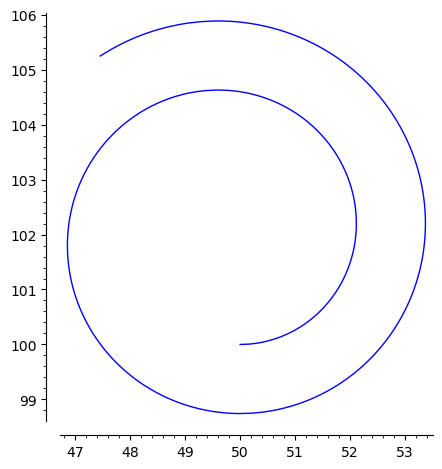

In [495]:
test_turn_displacement = [
    expr.subs(v_0 = 10, a = 5, theta = pi / 4, x_0 = 50, y_0 = 100, omega = 5, theta_0 = 0)
    for expr in [turn_displacement_x, turn_displacement_y]
]

parametric_plot((test_turn_displacement[0].rhs(), test_turn_displacement[1].rhs()), (t, 0, 2))

If the acceleration `a` of the turn is larger than `0` the turn ends to be a spiral as shown above and if the acceleration is zero it will end up being a circle.

## Creating maneuvers

A normal turn is composed of 3 maneuvers.

- A decelartion into the turn
- The turn
- Acceleration after the turn

Let's start with a few simplifying assumptions:

- The craft has a constant acceleration
- Acceleration and deceleration have the same magnitude. Therefore if the craft decelerates into a turn with `a=-100` then the acceleration after turn will be `a=100`
- The turn itself has zero acceleration

```
TODO: Try out a formula where the incoming and leaving accelerations can have different magnitudes and figure out how it would affect the turn acceleration
```

First let's start with modelling a point class

In [496]:
from dataclasses import dataclass

@dataclass
class Point:
    x: float
    y: float

    def length(self):
        return sqrt(self.x*self.x+self.y*self.y)

    def sub(self, other: Point):
        return Point(other.x - self.x, other.y - self.y)

    def normalize(self):
        len = self.length()
        return Point(self.x / len, self.y / len)

Now let's define a agent, and 2 maneuvers that will be used to create the initial path:

- Acceleration maneuver
- Static turn maneuver

In [497]:
from dataclasses import dataclass

@dataclass
class Agent:
    acceleration: float
    max_angular_velocity: float

@dataclass
class AccelerationManeuver:
    position: Point
    v_0: float
    acceleration: float
    duration: float
    angle: float

    def end_position(self):
        return self.point_at(duration)

    def point_at(self, time):
        displ = [
            expr.subs(
                t = time,
                v_0 = self.v_0,
                a = self.acceleration,
                theta = self.angle,
                x_0 = self.position.x,
                y_0 = self.position.y)
            for expr in [straight_displacement_x, straight_displacement_y]
        ]
        return Point(displ[0].rhs().n(), displ[1].rhs().n())

    def plot(self):
        displ = [
            expr.subs(
                v_0 = self.v_0,
                a = self.acceleration,
                theta = self.angle,
                x_0 = self.position.x,
                y_0 = self.position.y)
            for expr in [straight_displacement_x, straight_displacement_y]
        ]
        
        return parametric_plot((displ[0].rhs(), displ[1].rhs()), (t, 0, self.duration), color = 'red' if self.acceleration < 0 else 'green')
    
@dataclass
class StaticTurn:
    position: Point
    theta_0: float
    angular_velocity: float
    duration: float

    def end_position(self):
         return self.position

    def plot(self):
        radius = 5
        return parametric_plot((
            self.position.x + radius * cos(self.theta_0 + self.angular_velocity * t),
            self.position.y + radius * sin(self.theta_0 + self.angular_velocity * t)
        ), (t, 0, self.duration), color='magenta')

Now using the above classes let's define an algorithm to create an initial set of maneuvers, where the agent will accelerate and stop before reaching each point and then perform a static turn.

So given a set of 3 points we would have the following maneuvers:

- An acceleration maneuver with `a = agent.acceleration` that stops at the middle of the first two points `(50, 25)`
- A deceleration maneuver with `a = - agent.acceleration` that slows down to zero at the second point.
- A static turn maneuver that will turn towards the third point.
- A acceleration maneuver with `a = agent.acceleration` that stops at the middle of the last two points.
- A deceleration maneuver `a = - agent.acceleration` that stops at the last point.

In [498]:
import math

def normalize_angle(angle):
    return math.fmod((angle + 2 * pi).n(), (2 * pi).n())

def min_angle_between(angle_a, angle_b):
    raw_difference = angle_b - angle_a;
    min_angle = math.fmod(abs(raw_difference), (2 * pi).n());

    if min_angle > pi:
      min_angle = (2 * pi) - min_angle;
      raw_difference = -raw_difference

    is_clockwise = True if raw_difference < 0 else False

    return (min_angle, is_clockwise)


def create_acc_decc_maneuver(agent, from_point, to_point, next_point):
    # create acceleration and deceleration maneuvers going from `from_point` to `to_point`
    mid = Point((from_point.x + to_point.x) / 2, (from_point.y + to_point.y) / 2)
    # d = 1/2 * a * t^2
    # t = sqrt((2 * d) / a)
    duration = sqrt(2 * mid.sub(from_point).length() / agent.acceleration)

    # v = a * t
    velocity_at_mid_point = agent.acceleration * duration

    # now let's calculate angles of the acceleration and deceleration maneuver
    direction_acc_decc = from_point.sub(to_point)
    angle_acc_decc = normalize_angle(atan2(direction_acc_decc.y, direction_acc_decc.x))

    # The craft will accelerate towards mid point and from there
    # it will take the same time to decelerate back to zero
    acc = AccelerationManeuver(from_point, 0, agent.acceleration, duration, angle_acc_decc)
    dec = AccelerationManeuver(mid, velocity_at_mid_point, -agent.acceleration, duration, angle_acc_decc)

    if next_point == None:
        return [acc, dec]

    # if there is another point after these maneuvers we will create a static turn towards that point
    direction_towards_next_point = to_point.sub(next_point)
    angle_towards_next_point = normalize_angle(atan2(direction_towards_next_point.y, direction_towards_next_point.x))
    (angle_between, is_clockwise) = min_angle_between(angle_acc_decc, angle_towards_next_point)
    turn_duration = abs(angle_between / agent.max_angular_velocity)

    turn_maneuver = StaticTurn(
        to_point,
        angle_acc_decc,
        -agent.max_angular_velocity if is_clockwise else agent.max_angular_velocity,
        turn_duration)
    
    return [acc, dec, turn_maneuver]

def create_initial_maneuvers(agent, points):
    acc_dec_maneuvers = [x for i in range(len(points) - 1) for x in create_acc_decc_maneuver(
        agent,
        points[i],
        points[i+1],
        points[i+2] if len(points) > i + 2 else None)]

    return acc_dec_maneuvers

For testing purposes let's draw out our maneuvers. Red colored maneuvers will be decelerations, green colored accelerations and blue arcs will sign static rotations.

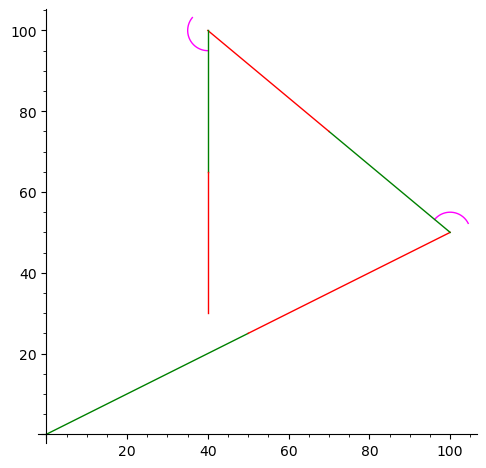

In [499]:
from functools import reduce

agent = Agent(100, 15)

path = [
    Point(0, 0),
    Point(100, 50),
    Point(40, 100),
    Point(40, 30)
]

maneuvers = create_initial_maneuvers(agent, path)

show(reduce(lambda x, y: x + y, [x.plot() for x in maneuvers]))

## Creating smooth turns

Right now our craft would accelerate at the beginning than mid-path start decelerating all the way to zero, then perform a turn in place and continue the loop. That is not very effective.

We will define a turn that will start at deceleration phase and end somewhere in the acceleration phase. We will use te following facts:

- The beginning point of the turn lies on the deceleration maneuver (we can use the parametric displacement formulas for that)
- The end point of the turn lies on the next acceleration maneuver (with can use the parametric displacement formulas as well for that)
- The tangent of the turn at the end of the turn will be equal to the slope of the acceleration move
- Since acceleration of the turn itself is zero, the velocity at the beginning point of the turn and the end point of the turn will be the same

Let's start by formulating some equations:

### Turn curve tangent

Since we know the curve will form a circle, we can convert it into a cartesian equation and then perform a implicit differentiation

In [500]:
turn_displacement_for_cos_theta = solve(turn_displacement_x, cos(theta_0 + omega * t))[0]
turn_displacement_for_sin_theta = solve(turn_displacement_y, sin(theta_0 + omega * t))[0]
turn_displacement_cartesian = turn_displacement_for_cos_theta.rhs()^2 + turn_displacement_for_sin_theta.rhs()^2 == 1
turn_displacement_tangent = derivative(turn_displacement_cartesian - 1, y).lhs()/derivative(turn_displacement_cartesian - 1, x).lhs()

turn_displacement_tangent = turn_displacement_tangent.subs(a = 0) #since the turn isn't going to have acceleretation let's substitute a with zero

turn_displacement_tangent

(omega^2*y - omega^2*y_0 + (omega*cos(omega*t + theta_0) - omega*cos(theta_0))*v_0)/(omega^2*x - omega^2*x_0 - (omega*sin(omega*t + theta_0) - omega*sin(theta_0))*v_0)

## Preparing deceleration and acceleration equations

In the above we can see that we have variables x, y and x_0, y_0. Those are going to be the endpoints of the turn. We can define them using the displacement equations of the deceleration and acceleration turns

In [501]:
var('theta_dec x_0dec y_0dec x_dec y_dec v_0dec t_beg')

deceleration_maneuver_xy = [
    expr.subs(a=-a, theta=theta_dec, v_0=v_0dec, x_0=x_0dec, y_0=y_0dec, x=x_dec, y=y_dec, t=t_beg)
    for expr in [straight_displacement_x, straight_displacement_y]
]

var('theta_acc x_0acc y_0acc x_acc y_acc t_end')

acceleration_maneuver_xy = [
    expr.subs(theta=theta_acc,v_0=0, x_0=x_0acc, y_0=y_0acc, x=x_acc, y=y_acc, t = t_end)
    for expr in [straight_displacement_x, straight_displacement_y]
]

We can say that `omega*t+theta_0` from the tangent equation equals to `theta_acc`. Let's also rename v_0 to v_0turn so it doesn't conflict with other potential initial velocities

In [502]:
var('t_turn v_0turn')

turn_displacement_tangent = turn_displacement_tangent.subs(omega*t+theta_0==theta_acc, v_0==v_0turn).subs(theta_0=theta_dec)

turn_displacement_tangent

(omega^2*y - omega^2*y_0 + (omega*cos(theta_acc) - omega*cos(theta_dec))*v_0turn)/(omega^2*x - omega^2*x_0 - (omega*sin(theta_acc) - omega*sin(theta_dec))*v_0turn)

Now to equate the tangent to the slope of the deceleration maneuver

In [503]:
eq = tan(theta_acc)==turn_displacement_tangent

eq

tan(theta_acc) == (omega^2*y - omega^2*y_0 + (omega*cos(theta_acc) - omega*cos(theta_dec))*v_0turn)/(omega^2*x - omega^2*x_0 - (omega*sin(theta_acc) - omega*sin(theta_dec))*v_0turn)

Now we can start substituting the end points of the turn

In [504]:
eq = eq.subs([
    x==acceleration_maneuver_xy[0].rhs(),
    y==acceleration_maneuver_xy[1].rhs(),
    x_0==deceleration_maneuver_xy[0].rhs(),
    y_0==deceleration_maneuver_xy[1].rhs(),
])

eq.variables()

(a,
 omega,
 t_beg,
 t_end,
 theta_acc,
 theta_dec,
 v_0dec,
 v_0turn,
 x_0acc,
 x_0dec,
 y_0acc,
 y_0dec)

From the variables listed above we can see that almost all are known

- a = agent's acceleration
- omega = angular velocity for the turn
- t_beg = time on the acceleration move when the turn begins (!unknown)
- t_end = time on the deceleration move when the turn begins (!unknown)
- theta_acc = angle of the accleration move
- theta_dec = angle of the deceleration move
- v_0dec = initial velocity for the deceleration move
- v_0turn = initial velocity for the turn (!unknown)
- x_0acc = initial X coordinate of the acceleration move
- x_0dec = initial X coordinate of the deceleration move
- y_0acc = initial Y coordinate of the acceleration move
- y_0dec = initial Y coordinate of the deceleration move

So we have three unknowns `t_beg` `t_end` and `v_0turn`

We know that `t_end` will be somewhere on the acceleration move where the velocity will be equal to `v_0turn`
Therefore we can use the velocity equation: `v_0turn == v_0acc + a * t_end` we know that initial velocity of the acceleration move is zero so:
`v_0turn == a * t_end` and in terms of t_end: `t_end == v_0turn/a`

In [505]:
eq = eq.subs(t_end == v_0turn/a)

eq.variables()

(a,
 omega,
 t_beg,
 theta_acc,
 theta_dec,
 v_0dec,
 v_0turn,
 x_0acc,
 x_0dec,
 y_0acc,
 y_0dec)

That leaves us with one more variable to eliminate. Let's eliminate `v_0turn`. We can formulate `v_0turn` as `v_0turn == v_0dec - a * t_beg` since it is going to be equal to a velocity on the deceleration maneuver at the beginning of the turn.

In [506]:
eq = eq.subs(v_0turn == v_0dec - a * t_beg)

eq.variables()

(a, omega, t_beg, theta_acc, theta_dec, v_0dec, x_0acc, x_0dec, y_0acc, y_0dec)

Now the only unknown remaining is `t_beg` let's solve the equation for that variable:

In [507]:
begin_of_turn_eq = solve(eq, t_beg)

def simp(f):
    old = f
    new = old.simplify_full()
    while 1:
        if hash(new) == hash(old):
            return old
        else:
            old = new
            new = new.simplify_full()

begin_of_turn_eq = [
    simp(expr)
    for expr in begin_of_turn_eq
]

begin_of_turn_eq

[t_beg == (a*cos(theta_acc)*cos(theta_dec) + a*sin(theta_acc)*sin(theta_dec) + (omega*cos(theta_dec)*sin(theta_acc) - omega*cos(theta_acc)*sin(theta_dec))*v_0dec - sqrt(-(a^2*cos(theta_acc)^2 + 2*a^2*cos(theta_acc)*cos(theta_dec) + (2*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc)*sin(theta_dec) - omega^2*cos(theta_acc)^2 + (2*omega^2*cos(theta_acc)^2 - omega^2)*cos(theta_dec)^2)*v_0dec^2 - (2*a^2*cos(theta_acc)^2 - a^2)*cos(theta_dec)^2 - 2*a^2 - 2*(a*omega^2*cos(theta_acc)*sin(theta_acc)*sin(theta_dec) + (a*omega^2*cos(theta_acc)^2 - a*omega^2)*cos(theta_dec))*x_0acc + 2*(a*omega^2*cos(theta_acc)*sin(theta_acc)*sin(theta_dec) + (a*omega^2*cos(theta_acc)^2 - a*omega^2)*cos(theta_dec))*x_0dec - 2*(a*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a*omega^2*cos(theta_acc)^2*sin(theta_dec))*y_0acc + 2*(a*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a*omega^2*cos(theta_acc)^2*sin(theta_dec))*y_0dec - 2*(a^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a^2*sin(theta_acc))*sin(theta_dec))/cos(theta_acc)^2)*cos(theta_acc) - a)/(a*omega*cos(theta_dec)*sin(theta_acc) - a*omega*cos(theta_acc)*sin(theta_dec)),
 t_beg == (a*cos(theta_acc)*cos(theta_dec) + a*sin(theta_acc)*sin(theta_dec) + (omega*cos(theta_dec)*sin(theta_acc) - omega*cos(theta_acc)*sin(theta_dec))*v_0dec + sqrt(-(a^2*cos(theta_acc)^2 + 2*a^2*cos(theta_acc)*cos(theta_dec) + (2*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc)*sin(theta_dec) - omega^2*cos(theta_acc)^2 + (2*omega^2*cos(theta_acc)^2 - omega^2)*cos(theta_dec)^2)*v_0dec^2 - (2*a^2*cos(theta_acc)^2 - a^2)*cos(theta_dec)^2 - 2*a^2 - 2*(a*omega^2*cos(theta_acc)*sin(theta_acc)*sin(theta_dec) + (a*omega^2*cos(theta_acc)^2 - a*omega^2)*cos(theta_dec))*x_0acc + 2*(a*omega^2*cos(theta_acc)*sin(theta_acc)*sin(theta_dec) + (a*omega^2*cos(theta_acc)^2 - a*omega^2)*cos(theta_dec))*x_0dec - 2*(a*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a*omega^2*cos(theta_acc)^2*sin(theta_dec))*y_0acc + 2*(a*omega^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a*omega^2*cos(theta_acc)^2*sin(theta_dec))*y_0dec - 2*(a^2*cos(theta_acc)*cos(theta_dec)*sin(theta_acc) - a^2*sin(theta_acc))*sin(theta_dec))/cos(theta_acc)^2)*cos(theta_acc) - a)/(a*omega*cos(theta_dec)*sin(theta_acc) - a*omega*cos(theta_acc)*sin(theta_dec))]

Now the equation is quite large, and it has two solution. Let's create an environment where we can test it.

First let's start with defining a `DynamicTurn` maneuver

In [508]:
@dataclass
class DynamicTurnManeuver:
    position: Point
    v_0: float
    duration: float
    theta_0: float
    angular_velocity: float

    def end_position(self):
        displ = [
            expr.subs(
                t = self.duration,
                v_0 = self.v_0,
                a = 0,
                omega = self.angular_velocity,
                theta_0 = self.theta_0,
                x_0 = self.position.x,
                y_0 = self.position.y)
            for expr in [turn_displacement_x, turn_displacement_y]
        ]
        return Point(displ[0].rhs().n(), displ[1].rhs().n())

    def plot(self):
        displ = [
            expr.subs(
                v_0 = self.v_0,
                a = 0,
                omega = self.angular_velocity,
                theta_0 = self.theta_0,
                x_0 = self.position.x,
                y_0 = self.position.y)
            for expr in [turn_displacement_x, turn_displacement_y]
        ]

        return parametric_plot((displ[0].rhs(), displ[1].rhs()), (t, 0, self.duration), color = 'blue')

Now let's create a function that will go through the maneuvers we generated in the previous step and start replacing them with these dynamic turn maneuvers.

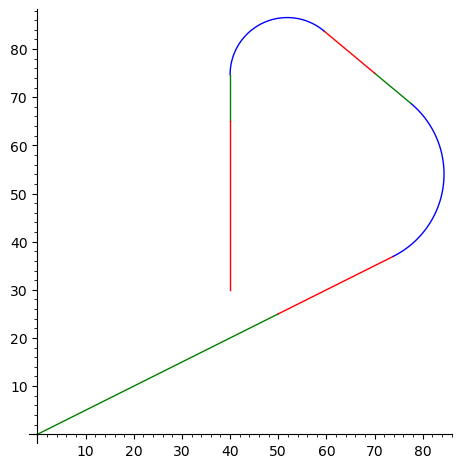

In [509]:
# this function will loop until the the maximum angular velocity trying to find a suitable minimum angular velocity for a turn
def find_suitable_turn(agent, deceleration, turn, acceleration, equation):
    for i in range(1, agent.max_angular_velocity):
        begin_of_turn_eq_subs = equation.rhs().subs([
            a == agent.acceleration,
            omega == (i if turn.angular_velocity > 0 else -i),
            theta_acc == acceleration.angle,
            theta_dec == deceleration.angle,
            v_0dec == deceleration.v_0,
            x_0acc == acceleration.position.x,
            y_0acc == acceleration.position.y,
            x_0dec == deceleration.position.x,
            y_0dec == deceleration.position.y,
        ]);
    
        t_begin = begin_of_turn_eq_subs.n()

        if t_begin < 0 or t_begin > deceleration.duration:
            continue

        turn_v0 = deceleration.v_0 - agent.acceleration * t_begin
        t_end = turn_v0 / agent.acceleration

        if t_end < 0 or t_end > acceleration.duration:
            continue

        return t_begin, turn_v0.n(), t_end.n(), i if turn.angular_velocity > 0 else -i
        
    return None

# we have to consider both solutions. We can calulate the result for both of then and then
# check which one is better
# better means that the turn is longer
def find_suitable_turn_in_equation_set(agent, deceleration, turn, acceleration):
    result_0 = find_suitable_turn(agent, deceleration, turn, acceleration, begin_of_turn_eq[0])
    result_1 = find_suitable_turn(agent, deceleration, turn, acceleration, begin_of_turn_eq[1])

    if result_0 == None:
        return result_1

    if result_1 == None:
        return result_0

    t_begin_0, turn_v0_0, t_end_0, turn_angular_velocity_0 = result_0
    t_begin_1, turn_v0_1, t_end_1, turn_angular_velocity_1 = result_1

    if turn_v0_0 > turn_v0_1:
        return result_0

    return result_1

def smooth_triplet(agent, deceleration, turn, acceleration):
    # first let's calculate the beginning of the turn maneuver
    result = find_suitable_turn_in_equation_set(agent, deceleration, turn, acceleration)
    
    # In some cases when the angle is too sharp for the maximum angular velocity to make the turn
    # it's better to just stop and turn
    if result == None:
        return deceleration, turn, acceleration

    t_begin, turn_v0, t_end, turn_angular_velocity = result
    
    turn_position = deceleration.point_at(t_begin)
    turn_duration = abs(turn.duration * turn.angular_velocity / turn_angular_velocity)

    turn = DynamicTurnManeuver(turn_position, turn_v0, turn_duration, turn.theta_0, turn_angular_velocity)

    # Modify the deceleration maneuver to end when the turn begins
    deceleration = AccelerationManeuver(deceleration.position, deceleration.v_0, deceleration.acceleration, t_begin, deceleration.angle)

    # Modify the acceleration maneuver to begin when the turn ends
    acceleration = AccelerationManeuver(turn.end_position(), turn_v0, acceleration.acceleration, acceleration.duration - t_end, acceleration.angle)

    return deceleration, turn, acceleration

def smooth_maneuvers(agent, maneuvers):
    i = 0
    result = []
    while i < len(maneuvers):
        if i < len(maneuvers) - 2 and isinstance(maneuvers[i+1], StaticTurn):
            a, b, c = smooth_triplet(agent, maneuvers[i], maneuvers[i+1], maneuvers[i+2])
            result.extend([a, b, c])
            i += 3
        else:
            result.append(maneuvers[i])
            i += 1
    return result

show(reduce(lambda x, y: x + y, [x.plot() for x in smooth_maneuvers(agent, maneuvers)]))

Let's create a little bit more complex scenario

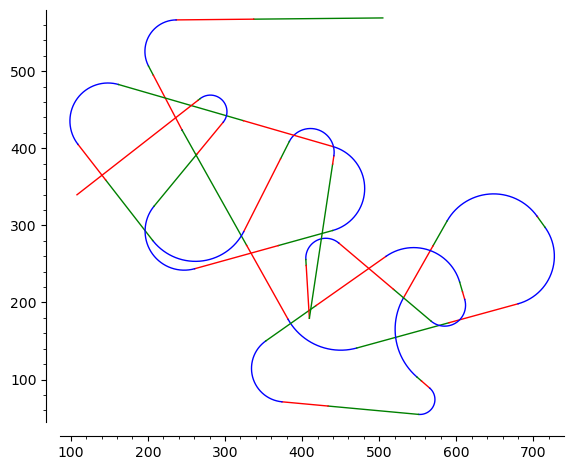

In [510]:
from functools import reduce

agent2 = Agent(200, 15)

path2 = [
    Point(504.67307789142006, 569.001009371967),
    Point(169.77533322508265, 565.7935531659497),
    Point(244.43593362240142, 423.42460489734384),
    Point(411.7858385033319, 124.68302316108905),
    Point(769.0004590478054, 222.6613719440425),
    Point(641.4068595802058, 399.6527353583185),
    Point(498.2169123969385, 147.2829611722144),
    Point(611.2450965268519, 49.27388959089667),
    Point(256.183483972298, 82.00567234484227),
    Point(580.1114837249534, 309.93369502550456),
    Point(635.9946214056359, 117.67834356440154),
    Point(401.1787868364831, 316.34482424865126),
    Point(409.458114810826, 179.46827078985373),
    Point(469.76312167088815, 579.4554362028147),
    Point(274.28190360677735, 192.92893037616517),
    Point(16.177082330883152, 524.8426103707741),
    Point(632.0080820434804, 346.59351283512),
    Point(105.92627235753902, 200.86797988652117),
    Point(421.99000840778854, 584.697544883629),
    Point(108.05371883619745, 339.64879224245476)
]

maneuvers2 = create_initial_maneuvers(agent2, path2)
show(reduce(lambda x, y: x + y, [x.plot() for x in smooth_maneuvers(agent2, maneuvers2)]))

Let's generate a set of javascript expressions for use in the local demo:

In [511]:
import sympy
from sage.interfaces.sympy import sympy_init

def sage_to_sympy(sage_expr):
    return sympy.sympify(str(sage_expr))

def sympy_to_javascript(sympy_expr):
    return sympy.printing.jscode(sympy_expr)

print("Variables:")
print(begin_of_turn_eq[0].variables())

print("First variant:")

sym_expr_0 = sympy.sympify(begin_of_turn_eq[0])
common_subexpressions, simplified_exprs = sympy.cse(sym_expr_0)

print("Common Subexpressions:")
for subexp in common_subexpressions:
    left = sage_to_sympy(subexp[0]._sage_())
    right = sage_to_sympy(subexp[1]._sage_())
    
    left_js = sympy_to_javascript(left)
    right_js = sympy_to_javascript(right)

    print(f"const {left_js} = {right_js}")

print("\nSimplified Expression:")
for simp in simplified_exprs:
    simp_sympy = sage_to_sympy(simp._sage_())
    simp_js = sympy_to_javascript(simp._sage_())
    print(simp_js)

print("\n\nSecond variant:")
sym_expr_0 = sympy.sympify(begin_of_turn_eq[1])
common_subexpressions, simplified_exprs = sympy.cse(sym_expr_0)

print("Common Subexpressions:")
for subexp in common_subexpressions:
    left = sage_to_sympy(subexp[0]._sage_())
    right = sage_to_sympy(subexp[1]._sage_())
    
    left_js = sympy_to_javascript(left)
    right_js = sympy_to_javascript(right)

    print(f"const {left_js} = {right_js}")

print("\nSimplified Expression:")
for simp in simplified_exprs:
    simp_sympy = sage_to_sympy(simp._sage_())
    simp_js = sympy_to_javascript(simp._sage_())
    print(simp_js)

Variables:
(a, omega, t_beg, theta_acc, theta_dec, v_0dec, x_0acc, x_0dec, y_0acc, y_0dec)
First variant:
Common Subexpressions:
const x0 = Math.cos(theta_dec)
const x1 = Math.sin(theta_acc)
const x2 = x0*x1
const x3 = omega*x2
const x4 = Math.cos(theta_acc)
const x5 = Math.sin(theta_dec)
const x6 = x4*x5
const x7 = omega*x6
const x8 = x0*x4
const x9 = Math.pow(x4, 2)
const x10 = Math.pow(a, 2)
const x11 = 2*x10
const x12 = Math.pow(x0, 2)
const x13 = x1*x10
const x14 = Math.pow(omega, 2)
const x15 = a*x14
const x16 = x14*x9
const x17 = a*x16
const x18 = 2*x15*x2*x4 - 2*x17*x5
const x19 = -2*x0*(x15 - x17) + 2*x1*x15*x6

Simplified Expression:
t_beg == (a*x1*x5 + a*x8 - a + v_0dec*(x3 - x7) - x4*Math.sqrt(-(Math.pow(v_0dec, 2)*(-x12*(x14 - 2*x16) + 2*x14*x2*x6 - x16) + x10*x9 + x11*x8 - x11 - x12*(-x10 + x11*x9) - x18*y_0acc + x18*y_0dec - x19*x_0acc + x19*x_0dec - 2*x5*(x13*x8 - x13))/x9))/(a*x3 - a*x7)


Second variant:
Common Subexpressions:
const x0 = Math.cos(theta_dec)
const x1 =